[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/CoolandHot/DATA5709Capstone/blob/main/DATA5709_Capstone_Evaluation_of_ARIMA_and_LSTM.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib.dates import DateFormatter
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = y_true.copy()
    epsilon = np.where(epsilon==0, np.mean(y_true), epsilon) # in case divide by 0
    mape = np.abs(y_pred - y_true) / np.abs(epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)

## <font color='yellow'>Load</font> data

Load the preprocessed datasets, and the predicted data of ARIMA and LSTM, then evaluate and plot

In [ ]:
# under "/content/drive/Shareddrives/Education/5709_Capstone/"
!gdown --id "1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx"
!gdown --id "1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL"

with open("proceeded_pickup.pickle", "rb") as f:
    (taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand) = pickle.load(f)
with open("proceeded_dropoff.pickle", "rb") as f:
    (taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply) = pickle.load(f)

taxi_demands = [taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand]
taxi_supplies = [taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply]
taxi_names = ["green", "yellow", "uber", "lyft", "via"]

Downloading...
From: https://drive.google.com/uc?id=1ltIU2HPfB8OInrCz0d2rV0Up52nPk7Vx
To: /content/proceeded_dropoff.pickle
141MB [00:01, 126MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xKa6WDhKfYT0wX-AZV2P0N_YKynOjTJL
To: /content/proceeded_pickup.pickle
141MB [00:01, 95.5MB/s]


Plot diagrams of LSTM and ARIMA prediction against the target values.

In [ ]:
# plt.style.use('ggplot')
# plt.style.use('default')

def compute_mape_mse(col, taxi_name, pickup_dropoff):
    feature = 'demand' if pickup_dropoff =="pickup" else 'supply'
    # ARIMA
    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/"+pickup_dropoff+"_prediction_"+taxi_name+"_column"+ str(col)+".pkl", "rb") as f:
        (ARIMA_pred, testset) = pickle.load(f)

    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'MAPE'] = mean_absolute_percentage_error(testset, ARIMA_pred)
    # ARIMA_model_MSE.loc[(taxi_name, feature, col), 'R2'] = r2_score(testset, ARIMA_pred)
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'MSE'] = mean_squared_error(testset, ARIMA_pred)
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'RMSE'] = mean_squared_error(testset, ARIMA_pred, squared=False)
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'MAE'] = mean_absolute_error(testset, ARIMA_pred)

    # LSTM
    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/"+pickup_dropoff+"_prediction_"+taxi_name+".pkl", "rb") as f:
        (pred_all_location, true_all_location) = pickle.load(f)
    LSTM_pred, LSTM_true = pred_all_location[:1008, col-1].round().astype(int), true_all_location[:1008, col-1]
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'MAPE'] = mean_absolute_percentage_error(LSTM_true, LSTM_pred)
    # LSTM_model_MSE.loc[(taxi_name, feature, col), 'R2'] = r2_score(LSTM_true, LSTM_pred)
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'MSE'] = mean_squared_error(LSTM_true, LSTM_pred)
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'RMSE'] = mean_squared_error(LSTM_true, LSTM_pred, squared=False)
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'MAE'] = mean_absolute_error(LSTM_true, LSTM_pred)

    return pd.DataFrame({"ARIMA_predict": ARIMA_pred, "LSTM_predict": LSTM_pred, "Target": testset}, index=testset.index)



########################################################
####                  Evaluation                   #####
########################################################
colNums = [37, 41, 61, 74, 75, 79, 138, 265]

multiIndex = pd.MultiIndex.from_product([taxi_names, ['demand', 'supply'], colNums], names=["vendor", "feature", "location"])
ARIMA_model_MSE = pd.DataFrame(index=multiIndex, columns = ['MAPE','MAE','MSE', 'RMSE'])
ARIMA_model_MSE = ARIMA_model_MSE.sort_index() # this will get rid of the PerformanceWarning: indexing past lexsort depth may impact performance 

LSTM_model_MSE = ARIMA_model_MSE.copy()

# set xaxis AutoDateFormatter
plt.rcParams["date.autoformatter.day"] = "%A"


'''
# This aggregate all colNums in each subplots in a plt.figure

for i, taxi_name in enumerate(taxi_names):
    for feature in ['pickup', 'dropoff']:
        fig, axs = plt.subplots(len(colNums), sharex=True, sharey=True, figsize=(20, 10))
        fig.subplots_adjust(top=0.9, bottom=0.15) # all subplots topmost at 0.945
        fig.suptitle(r"ARIMA vs LSTM: $\bf{" + taxi_name + r"}$ taxi $\bf{" + feature + r"}$", y=0.945)

        for k, col in enumerate(colNums):
            pred_target = compute_mape_mse(col, taxi_name, feature)

            axs[k].plot(pred_target.index, pred_target['Target'], alpha=0.5, color = 'Gray')
            axs[k].plot(pred_target.index, pred_target[['LSTM_predict', 'ARIMA_predict']])
            # upper middle annotation
            axs[k].text(0.5, 0.9, "Location "+str(col), ha='center', va='top',
                    transform=axs[k].transAxes, # transform the x-y coordinates to use percentage
                    color='green')
        # x label
        fig.text(0.5, 0.09, 'Time frames', ha='center') # colab pyplot default version is 3.2.2, haven't implement figure.supxlabel()
        # y label
        fig.text(0.09, 0.5, 'Taxi amount', va='center', rotation='vertical') # if 3.4.1, we can use figure.supylabel()
        # only take the last one legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol = 3)
        # plt.show()
        fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMAvsLSTM/ARIMAvsLSTM_" + taxi_name + "_" + feature + "_ALL.svg", bbox_inches='tight')
'''

# this plots each diagram on one figure, better for document organization
for i, taxi_name in enumerate(taxi_names):
    for feature in ['pickup', 'dropoff']:
        for k, col in enumerate(colNums):
            plt.figure(figsize=(20,2))
            ax = plt.gca()
            pred_target = compute_mape_mse(col, taxi_name, feature)
            plt.plot(pred_target.index, pred_target['Target'], alpha=0.5, color = 'Gray', label="Target")
            plt.plot(pred_target.index, pred_target['LSTM_predict'], label='LSTM_predict')
            plt.plot(pred_target.index, pred_target['ARIMA_predict'], label='ARIMA_predict')
            plt.title(r"ARIMA vs LSTM: $\bf{" + taxi_name + r"}$ taxi $\bf{" + feature + r"}$")
            plt.text(0.5, 0.9, "Location "+str(col), horizontalalignment='center', verticalalignment='top',
                            transform=ax.transAxes, # transform the x-y coordinates to use percentage
                            color='green')
            plt.legend(loc='upper left', ncol=3)
            # plt.show()
            plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMAvsLSTM/ARIMAvsLSTM_" + taxi_name + "_" + feature + "_"+str(col)+".svg", bbox_inches='tight')


ARIMA_model_MSE.to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ARIMA_Evaluation_matrices.csv")
LSTM_model_MSE.to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/LSTM_Evaluation_matrices.csv")

Output hidden; open in https://colab.research.google.com to view.

## load evaluated metrics

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LSTM:


,MAPE,MAE,MSE,RMSE
0,65.38% ± 215.91%,2.7563 ± 2.6076,26.9734 ± 53.3878,3.7894 ± 3.5741


ARIMA:


,MAPE,MAE,MSE,RMSE
0,34.86% ± 13.57%,2.9002 ± 2.6964,29.1562 ± 53.6331,3.9987 ± 3.6515


ARIMA better than LSTM:


,MAPE,MAE,MSE,RMSE
0,-0.875646,0.049626,0.074863,0.052352


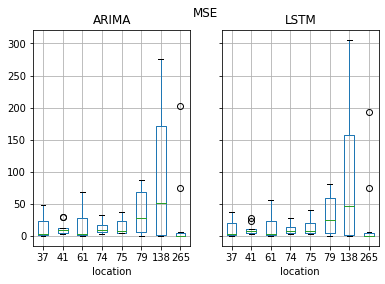

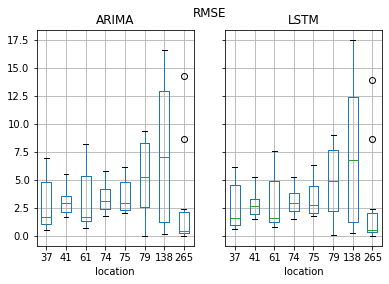

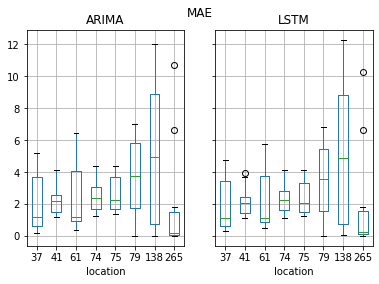

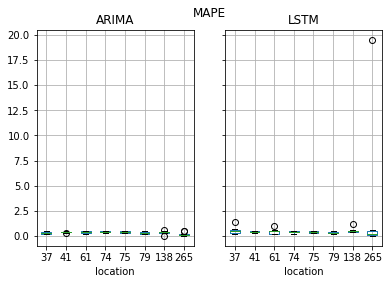

In [ ]:
ARIMA_model_MSE = pd.read_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ARIMA_Evaluation_matrices.csv", index_col=[0,1,2])
LSTM_model_MSE = pd.read_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/LSTM_Evaluation_matrices.csv", index_col=[0,1,2])
combined_matrices = pd.concat([LSTM_model_MSE, ARIMA_model_MSE], axis=1, keys=['LSTM', 'ARIMA'])

# -------------------------  Boxplot on overall MSE, MAE, MAPE

# convert multiindex from column to index for grouping
modelName_in_index = combined_matrices.stack(level=0)\
                        .reset_index(level=3)\
                        .rename(columns={'level_3': 'modelName'})\
                        .groupby('modelName')

modelName_in_index.boxplot(by='location', column='MSE')
plt.suptitle('MSE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_MSE.svg")

modelName_in_index.boxplot(by='location', column='RMSE')
plt.suptitle('RMSE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_RMSE.svg")

modelName_in_index.boxplot(by='location', column='MAE')
plt.suptitle('MAE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_MAE.svg")

modelName_in_index.boxplot(by='location', column='MAPE')
plt.suptitle('MAPE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_MAPE.svg")

# -------------------------  mean ± std on overall model

LSTM_avg = LSTM_model_MSE.agg([np.mean, np.std])
LSTM_avg['MAPE'] = LSTM_avg['MAPE'].apply(lambda x: '{:,.2%}'.format(x))
LSTM_avg[['MAE', 'MSE', 'RMSE']] = LSTM_avg[['MAE', 'MSE', 'RMSE']].applymap(lambda x: '{:,.4f}'.format(x))
LSTM_avg = LSTM_avg.applymap(str).apply(' ± '.join, axis = 0)

ARIMA_avg = ARIMA_model_MSE.agg([np.mean, np.std])
ARIMA_avg['MAPE'] = ARIMA_avg['MAPE'].apply(lambda x: '{:,.2%}'.format(x))
ARIMA_avg[['MAE', 'MSE', 'RMSE']] = ARIMA_avg[['MAE', 'MSE', 'RMSE']].applymap(lambda x: '{:,.4f}'.format(x))
ARIMA_avg = ARIMA_avg.applymap(str).apply(' ± '.join, axis = 0)

print("LSTM:")
display(pd.DataFrame(LSTM_avg).transpose())
print("ARIMA:")
display(pd.DataFrame(ARIMA_avg).transpose())
print("ARIMA better than LSTM:")
display(pd.DataFrame((ARIMA_model_MSE.mean(axis=0) - LSTM_model_MSE.mean(axis=0))/ARIMA_model_MSE.mean(axis=0)).transpose())

In [ ]:
# -------------------------  mean ± std on each model-vendor-feature
modelName_in_index = combined_matrices.stack(level=0)\
                        .reset_index(level=3)\
                        .rename(columns={'level_3': 'modelName'})\
                        .groupby(['modelName', 'vendor', 'feature'])
model_vendor_feature_avg = modelName_in_index.agg([np.mean, np.std])
model_vendor_feature_avg.columns = ["_".join(cols) for cols in model_vendor_feature_avg.columns.to_flat_index()]

model_vendor_feature_avg['MAPE'] = model_vendor_feature_avg[['MAPE_mean', 'MAPE_std']]\
                                        .applymap(lambda x: '{:,.2%}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['MAE'] = model_vendor_feature_avg[['MAE_mean', 'MAE_std']]\
                                        .applymap(lambda x: '{:,.4f}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['MSE'] = model_vendor_feature_avg[['MSE_mean', 'MSE_std']]\
                                        .applymap(lambda x: '{:,.4f}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['RMSE'] = model_vendor_feature_avg[['RMSE_mean', 'RMSE_std']]\
                                        .applymap(lambda x: '{:,.4f}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(model_vendor_feature_avg[['MAPE', 'MSE', 'MAE', 'RMSE']])
    display(combined_matrices)

MAPE                MSE  \
modelName vendor feature                                         
ARIMA     green  demand     28.95% ± 18.80%    4.4163 ± 6.5496   
                 supply      38.40% ± 9.50%    2.3495 ± 1.8269   
          lyft   demand     33.39% ± 12.04%  23.4479 ± 24.6756   
                 supply      34.46% ± 9.55%  31.0016 ± 26.0350   
          uber   demand     25.16% ± 11.61%  69.8512 ± 86.9815   
                 supply      25.82% ± 7.25%  86.7066 ± 72.9661   
          via    demand     42.11% ± 17.10%    3.0950 ± 2.6556   
                 supply     40.61% ± 16.67%    3.0804 ± 1.8612   
          yellow demand     39.48% ± 14.20%  47.0719 ± 92.7784   
                 supply      39.47% ± 7.96%  20.5413 ± 19.4325   
LSTM      green  demand     52.12% ± 35.90%    3.6037 ± 5.1702   
                 supply      51.21% ± 6.16%    1.9927 ± 1.5387   
          lyft   demand     31.92% ± 11.84%  21.5412 ± 24.2411   
                 supply      33.42% ± 9.09%  27.9432 ± 24.8718   
          uber   demand     26.01% ± 15.08%  69.8855 ± 98.4452   
                 supply      25.17% ± 8.90%  77.4916 ± 69.4337   
          via    demand     42.99% ± 17.60%    2.4282 ± 1.9120   
                 supply   285.92% ± 672.80%    2.4694 ± 1.3116   
          yellow demand     61.91% ± 37.21%  43.6089 ± 89.2008   
                 supply     41.49% ± 12.17%  18.7702 ± 17.2034   

                                      MAE             RMSE  
modelName vendor feature                                    
ARIMA     green  demand   1.0093 ± 1.1660  1.4959 ± 1.5780  
                 supply   0.8926 ± 0.5086  1.4066 ± 0.6512  
          lyft   demand   3.1515 ± 1.8113  4.2432 ± 2.4942  
                 supply   3.8449 ± 1.6435  5.1627 ± 2.2291  
          uber   demand   5.3323 ± 3.3424  7.1452 ± 4.6349  
                 supply   6.3678 ± 2.5152  8.6864 ± 3.5862  
          via    demand   1.1022 ± 0.6250  1.5757 ± 0.8365  
                 supply   1.0930 ± 0.5314  1.6194 ± 0.7233  
          yellow demand   3.3068 ± 4.0101  4.6044 ± 5.4375  
                 supply   2.9014 ± 1.5161  4.0476 ± 2.1800  
LSTM      green  demand   0.9368 ± 1.0343  1.3952 ± 1.3761  
                 supply   0.8578 ± 0.4515  1.3017 ± 0.5838  
          lyft   demand   2.9774 ± 1.7893  4.0256 ± 2.4693  
                 supply   3.6463 ± 1.6753  4.8746 ± 2.1861  
          uber   demand   5.1755 ± 3.4782  6.9660 ± 4.9409  
                 supply   5.9797 ± 2.5771  8.1416 ± 3.5786  
          via    demand   1.0029 ± 0.5355  1.4088 ± 0.7120  
                 supply   1.0378 ± 0.4220  1.4943 ± 0.5198  
          yellow demand   3.1625 ± 3.7205  4.4027 ± 5.2617  
                 supply   2.7861 ± 1.3798  3.8831 ± 2.0541

LSTM                                    \
                              MAPE        MAE         MSE       RMSE   
vendor feature location                                                
green  demand  37         0.709974   0.336310    0.399802   0.632299   
               41         0.433559   1.852183    6.312500   2.512469   
               61         0.446403   0.685516    1.122024   1.059256   
               74         0.430448   2.707341   14.453373   3.801759   
               75         0.354743   1.776786    6.389881   2.527821   
               79              NaN   0.008929    0.008929   0.094491   
               138        1.211971   0.059524    0.063492   0.251976   
               265        0.061508   0.067460    0.079365   0.281718   
       supply  37         0.649124   0.491071    0.608135   0.779830   
               41         0.491158   1.266865    3.086310   1.756790   
               61         0.488367   0.853175    1.555556   1.247219   
               74         0.465580   1.483135    4.499008   2.121086   
               75         0.485618   1.241071    3.326389   1.823839   
               79         0.529797   0.309524    0.373016   0.610750   
               138        0.455114   0.893849    2.104167   1.450575   
               265        0.531687   0.323413    0.388889   0.623610   
lyft   demand  37         0.270231   3.382937   19.273810   4.390195   
               41         0.389678   2.254960    8.975198   2.995864   
               61         0.266560   3.774802   23.673611   4.865554   
               74         0.439725   2.210317    8.424603   2.902517   
               75         0.420360   2.039683    7.059524   2.656976   
               79         0.279139   3.830357   27.905754   5.282590   
               138        0.402357   6.231151   76.899802   8.769253   
               265        0.085317   0.095238    0.117063   0.342145   
       supply  37         0.302223   3.422619   20.839286   4.565007   
               41         0.397855   2.145833    8.124008   2.850265   
               61         0.238564   3.684524   23.974206   4.896346   
               74         0.373280   2.257937    8.652778   2.941560   
               75         0.410200   2.105159    8.547619   2.923631   
               79         0.427900   3.276786   20.935516   4.575534   
               138        0.354049   5.649802   57.836310   7.605019   
               265        0.169450   6.627976   74.635913   8.639208   
uber   demand  37         0.190736   4.778770   37.681548   6.138530   
               41         0.290148   3.972222   27.279762   5.223003   
               61         0.171716   5.781746   56.726190   7.531679   
               74         0.262146   4.155754   27.564484   5.250189   
               75         0.267864   3.517857   22.125000   4.703722   
               79         0.194738   6.795635   81.605159   9.033557   
               138        0.601331  12.291667  305.976190  17.492175   
               265        0.102183   0.110119    0.125992   0.354954   
       supply  37         0.205065   4.660714   37.464286   6.120808   
               41         0.292803   3.710317   23.724206   4.870750   
               61         0.161785   5.572421   52.864087   7.270769   
               74         0.247307   4.015873   27.053571   5.201305   
               75         0.263503   4.108135   39.979167   6.322908   
               79         0.295975   5.829365   62.785714   7.923744   
               138        0.415798   9.649802  183.427579  13.543544   
               265        0.131553  10.290675  192.633929  13.879263   
via    demand  37         0.503810   1.106151    2.185516   1.478349   
               41         0.497616   1.135913    2.334325   1.527850   
               61         0.462303   0.883929    1.594246   1.262635   
               74         0.516470   1.143849    2.407738   1.551689   
               75         0.482099   1.278770    3.326389   1.823839  

In [ ]:
# ------ LSMT surpass ARIMA by %

combined_matrices[('(ARIMA-LSTM)/ARIMA', 'MAPE')] = combined_matrices[[('ARIMA', 'MAPE'), ('LSTM', 'MAPE')]].apply(lambda x: (x[0]-x[1]), axis = 1)
combined_matrices[('(ARIMA-LSTM)/ARIMA', 'MAE')] = combined_matrices[[('ARIMA', 'MAE'), ('LSTM', 'MAE')]].apply(lambda x: (x[0]-x[1]), axis = 1)
combined_matrices[('(ARIMA-LSTM)/ARIMA', 'MSE')] = combined_matrices[[('ARIMA', 'MSE'), ('LSTM', 'MSE')]].apply(lambda x: (x[0]-x[1]), axis = 1)
combined_matrices[('(ARIMA-LSTM)/ARIMA', 'RMSE')] = combined_matrices[[('ARIMA', 'RMSE'), ('LSTM', 'RMSE')]].apply(lambda x: (x[0]-x[1]), axis = 1)

modelName_in_index = combined_matrices['(ARIMA-LSTM)/ARIMA'].groupby(['vendor', 'feature'])
model_vendor_feature_avg = modelName_in_index.agg([np.mean, np.std])
model_vendor_feature_avg.columns = ["_".join(cols) for cols in model_vendor_feature_avg.columns.to_flat_index()]

model_vendor_feature_avg['MAPE'] = model_vendor_feature_avg[['MAPE_mean', 'MAPE_std']]\
                                        .applymap(lambda x: '{:,.2%}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['MAE'] = model_vendor_feature_avg[['MAE_mean', 'MAE_std']]\
                                        .applymap(lambda x: '{:,.2%}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['MSE'] = model_vendor_feature_avg[['MSE_mean', 'MSE_std']]\
                                        .applymap(lambda x: '{:,.2%}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)
model_vendor_feature_avg['RMSE'] = model_vendor_feature_avg[['RMSE_mean', 'RMSE_std']]\
                                        .applymap(lambda x: '{:,.2%}'.format(x))\
                                        .apply(lambda x: " ± ".join(x), axis = 1)


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(model_vendor_feature_avg[['MAPE', 'MSE', 'MAE', 'RMSE']])

MAPE                 MSE              MAE  \
vendor feature                                                            
green  demand     -23.18% ± 46.13%    81.26% ± 139.32%   7.25% ± 13.98%   
       supply     -12.81% ± 13.33%     35.68% ± 30.32%    3.48% ± 5.90%   
lyft   demand        1.48% ± 1.40%   190.67% ± 111.63%  17.41% ± 10.98%   
       supply        1.04% ± 3.98%   305.84% ± 306.22%  19.85% ± 11.08%   
uber   demand       -0.85% ± 4.07%  -3.44% ± 1,275.39%  15.69% ± 30.98%   
       supply        0.65% ± 3.84%   921.50% ± 642.55%  38.81% ± 23.60%   
via    demand       -0.88% ± 4.65%     66.68% ± 75.59%    9.93% ± 9.87%   
       supply   -245.31% ± 688.89%     61.10% ± 57.10%   5.52% ± 11.65%   
yellow demand     -22.43% ± 46.20%   346.30% ± 562.41%  14.43% ± 30.53%   
       supply       -2.02% ± 5.02%   177.11% ± 272.26%  11.53% ± 20.35%   

                           RMSE  
vendor feature                   
green  demand   10.06% ± 20.56%  
       supply    10.49% ± 7.57%  
lyft   demand   21.75% ± 12.14%  
       supply   28.82% ± 20.21%  
uber   demand   17.92% ± 47.25%  
       supply   54.47% ± 35.56%  
via    demand   16.69% ± 13.40%  
       supply   12.52% ± 20.68%  
yellow demand   20.17% ± 32.17%  
       supply   16.45% ± 18.34%

In [ ]:
# --------   multiindex slicing  --------
# ------  location 41 has an outlier in LSTM MAE --------
# ------  location 265 has two outliers in LSTM & ARIMA RMSE --------
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(combined_matrices.loc[(slice(None), slice(None), 41), (slice(None), 'MAE')])
    display(combined_matrices.loc[(slice(None), slice(None), 265), (slice(None), 'RMSE')])

LSTM     ARIMA (ARIMA-LSTM)/ARIMA
                              MAE       MAE                MAE
vendor feature location                                       
green  demand  41        1.852183  1.965278           0.113095
       supply  41        1.266865  1.339286           0.072421
lyft   demand  41        2.254960  2.478175           0.223214
       supply  41        2.145833  2.378968           0.233135
uber   demand  41        3.972222  4.141865           0.169643
       supply  41        3.710317  4.127976           0.417659
via    demand  41        1.135913  1.243056           0.107143
       supply  41        1.098214  1.204365           0.106151
yellow demand  41        1.922619  2.022817           0.100198
       supply  41        2.492063  2.604167           0.112103

LSTM      ARIMA (ARIMA-LSTM)/ARIMA
                              RMSE       RMSE               RMSE
vendor feature location                                         
green  demand  265        0.281718   0.281718           0.000000
       supply  265        0.623610   0.592613          -0.030996
lyft   demand  265        0.342145   0.342145           0.000000
       supply  265        8.639208   8.663518           0.024310
uber   demand  265        0.354954   0.354954           0.000000
       supply  265       13.879263  14.216858           0.337595
via    demand  265        0.031497   0.031497           0.000000
       supply  265        0.413080   0.089087          -0.323993
yellow demand  265        1.067652   1.196887           0.129235
       supply  265        2.424045   2.394397          -0.029648